# Housing Project


## Frame The Problem

The main objective of this project is to develop a model that can predict the pricing of each house in ames, iowa, given alot of other data. The current soultion is having experts manually estimate the housing price for each house. Which doesnt necessarly always result in a in estimates that are close to being correct, this process can be time cosuming and costly, to have experts do this manually for each house. 

This will be a multiple regression (since it has multiple features), univariate regression (since we are predicting one vaule - house price) promblem. 

For our performnce measure we will be using the Root mean square error (RMSE). Which is a typicall performce measure for regression problems. 

In [484]:
!pip install kaggle

In [3]:
import os 
from pathlib import Path
import pandas as pd
from kaggle.api.kaggle_api_extended import KaggleApi
import zipfile
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import FunctionTransformer
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.metrics import root_mean_squared_error
import joblib

In [4]:
def download_kaggle_dataset():
    api = KaggleApi()
    api.authenticate()

    dataset = 'house-prices-advanced-regression-techniques'
    file = 'train.csv'

    
    dataset_path = Path('dataset')
    dataset_path.mkdir(exist_ok=True)
    api.competition_download_file(dataset, file, path=str(dataset_path))
    csv_path = dataset_path / file
    return pd.read_csv(csv_path)
    
    

housing = download_kaggle_dataset()

train.csv: Skipping, found more recently modified local copy (use --force to force download)


In [83]:
housing.head()


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [86]:
housing.set_index('Id', inplace=True)

In [87]:
housing.info()

#missing vaules : Alley, MasVnrType, MasVnrType, MasVnrArea, BsmtQual, BsmtCond, BsmtExposure


<class 'pandas.core.frame.DataFrame'>
Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuilt    

In [88]:
housing.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [89]:
#orignally neighborhood but decided overall quality has more of a correlation 

In [90]:
housing['OverallQual'].unique()

array([ 7,  6,  8,  5,  9,  4, 10,  3,  1,  2])

In [91]:
housing['OverallQual'].value_counts()

OverallQual
5     397
6     374
7     319
8     168
4     116
9      43
3      20
10     18
2       3
1       2
Name: count, dtype: int64

In [92]:
strat_train_set , strat_test_set = train_test_split(housing, test_size=0.2, stratify=housing['OverallQual'], random_state=42)

In [93]:
rand_train_set , rand_test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [94]:
rand = rand_test_set['OverallQual'].value_counts() / len(rand_test_set)
strat = strat_test_set['OverallQual'].value_counts() / len(strat_test_set)
overall = housing['OverallQual'].value_counts() / len(housing)

In [95]:
Neighborhood_split = pd.DataFrame()
Neighborhood_split['overall'] = overall
Neighborhood_split['strat_split'] = strat
Neighborhood_split['random_split'] = rand

Neighborhood_split

,overall,strat_split,random_split
OverallQual,,,
5,0.271918,0.270548,0.304795
6,0.256164,0.256849,0.215753
7,0.218493,0.219178,0.208904
8,0.115068,0.113014,0.113014
4,0.079452,0.078767,0.095890
9,0.029452,0.030822,0.023973
3,0.013699,0.013699,0.013699
10,0.012329,0.013699,0.017123
2,0.002055,0.003425,0.006849


In [96]:
corr_matrix = housing.corr(numeric_only=True)

In [97]:
corr_matrix['SalePrice'].sort_values(ascending=False)

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64

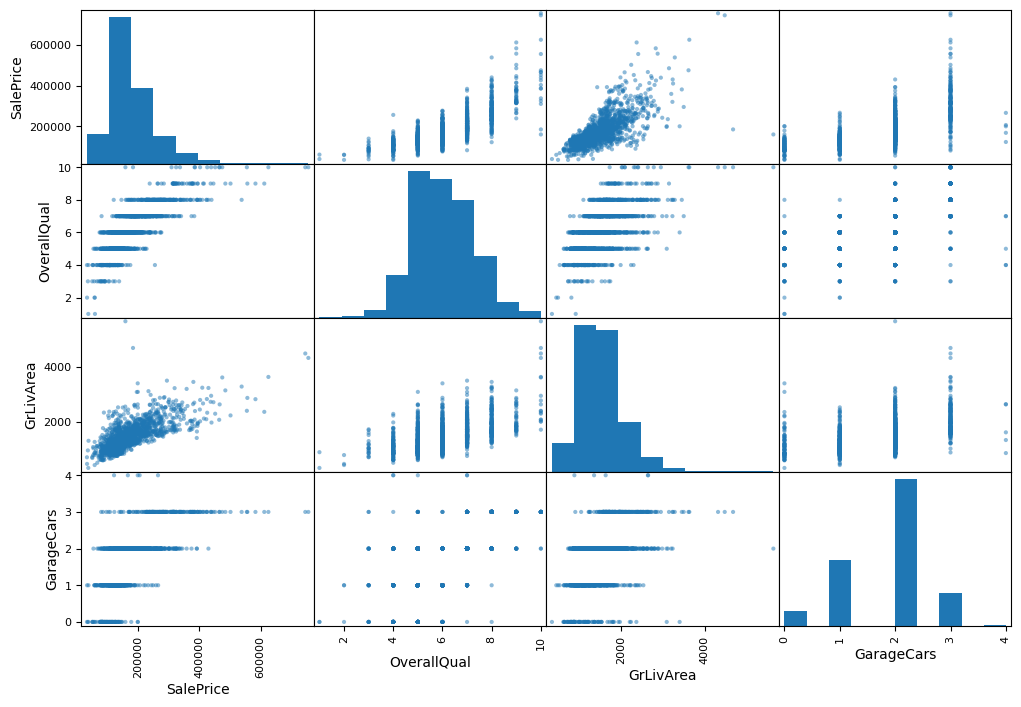

In [98]:
attr = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars']
scatter_matrix(housing[attr], figsize=(12, 8))
plt.show()

In [99]:
# will perform these tranformations in the single pipeline
'''

housing['totalSF'] = housing['TotalBsmtSF'] + housing['1stFlrSF'] + housing['2ndFlrSF']
housing['OverallScore'] = housing['OverallQual'] * housing['OverallCond'] #not as important
housing['HouseAge'] = housing['YrSold'] - housing['YearBuilt'] 
housing['YearsSinceRemodel'] = housing['YrSold'] - housing['YearRemodAdd']
housing['GarageScore'] =  housing['GarageCars'] * housing['GarageArea']
housing['TotalBath'] =  housing['FullBath'] + (housing['HalfBath'] * 0.5) + housing['BsmtFullBath'] + (housing['BsmtHalfBath'] * 0.5)

'''



"\n\nhousing['totalSF'] = housing['TotalBsmtSF'] + housing['1stFlrSF'] + housing['2ndFlrSF']\nhousing['OverallScore'] = housing['OverallQual'] * housing['OverallCond'] #not as important\nhousing['HouseAge'] = housing['YrSold'] - housing['YearBuilt'] \nhousing['YearsSinceRemodel'] = housing['YrSold'] - housing['YearRemodAdd']\nhousing['GarageScore'] =  housing['GarageCars'] * housing['GarageArea']\nhousing['TotalBath'] =  housing['FullBath'] + (housing['HalfBath'] * 0.5) + housing['BsmtFullBath'] + (housing['BsmtHalfBath'] * 0.5)\n\n"

array([[<Axes: title={'center': 'YearRemodAdd'}>]], dtype=object)

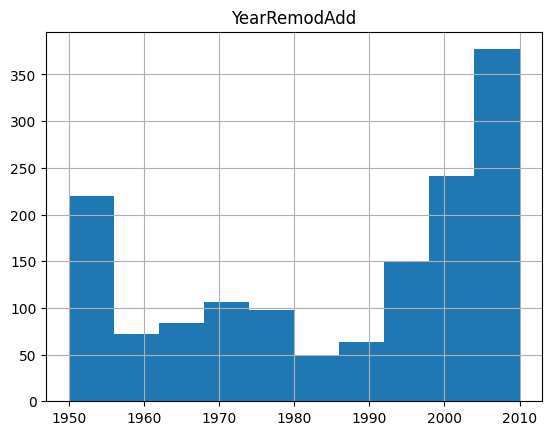

In [100]:
housing.hist("YearRemodAdd")

In [101]:
corr_matrix = housing.corr(numeric_only=True)
corr_matrix['SalePrice'].sort_values(ascending=False)

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64

In [102]:
new_col_attr = ['SalePrice', 'OverallQual', 'totalSF', 'GrLivArea',]
scatter_matrix(housing[new_col_attr], figsize=(12, 8))

KeyError: "['totalSF'] not in index"

KeyError: 'totalSF'

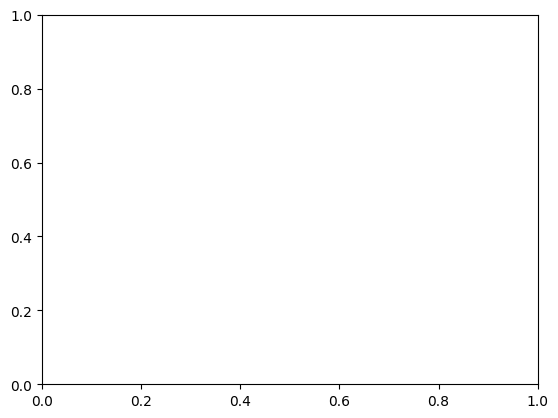

In [103]:
housing.plot(kind='scatter', x='totalSF', y='SalePrice', alpha=0.1, grid=True)

In [104]:

#making a copy of housing set 

housing = strat_train_set.drop('SalePrice', axis=1)
housing_label =  strat_train_set['SalePrice'].copy()

In [105]:
num_imputer = SimpleImputer(strategy='mean')
cat_imputer = SimpleImputer(strategy='Constat',fill_value='None')
                     

In [106]:
def missing_alot_vaules(df, threshold=0.80):
    low_col = []
    total_rows = len(df)

    for col in df.columns: 
        non_null_ratio = df[col].notna().sum() / total_rows
        if non_null_ratio < threshold:
            low_col.append(col)
    return low_col

missing_to_much = missing_alot_vaules(housing)

#assumption: might be to get rid of vaules , rather than replacing them with none overall 

In [107]:
housing.drop(missing_to_much, axis=1, inplace=True)

In [108]:
housing.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrArea', 'ExterQual',
       'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPor

In [109]:
def missing_values_col_names(df):
    obj_cols = df.select_dtypes(include=object).columns
    missing_obj = df[obj_cols].isnull().sum()
    col_with_null = missing_obj[missing_obj > 0].index.tolist()
    return col_with_null

col = missing_values_col_names(housing)
col

['BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Electrical',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond']

In [110]:
class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None)
        self.n_clusters = n_clusters
        self.gamma=gamma
        self.random_state=random_state

    def fit(self, X,y=None, sample_weight=None):
        self.kmeans = Kmeans()
        

SyntaxError: expected ':' (4294167319.py, line 2)

In [111]:
class LogTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, skew_threshold=1.0):
        self.skew_threshold = skew_threshold
        self.log_cols = []

    def fit(self, X, y=None):
        X_df = pd.DataFrame(X)
        self.log_cols = X_df.skew().abs()[X_df.skew().abs() > self.skew_threshold].index.tolist()
        return self
        
    def transform(self, X):
        X_df = pd.DataFrame(X).copy()
        X_df[self.log_cols] = np.log1p(X_df[self.log_cols])
        return X_df.values

    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            return np.array(self.log_cols)
        return np.array(input_features)

In [112]:
cat_pipeline = make_pipeline(
    SimpleImputer(strategy='constant', fill_value='None'),
    OneHotEncoder(handle_unknown='ignore'),
)

num_pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    LogTransformer(),
    StandardScaler()
)





In [113]:
class FeatureDropper(BaseEstimator, TransformerMixin):
    def __init__(self, features_to_drop=None):
        self.features_to_drop = features_to_drop or []

    def fit(self, X, y=None):
        return self  # Nothing to fit

    def transform(self, X):
        return X.drop(columns=self.features_to_drop, errors='ignore')

In [114]:
##this is all stuff for pickling stuff
from custom_transformers import (
    addition_pipeline,
    multiplication_pipeline,
    subtraction_pipeline,
    weighted_bathrooms_pipeline,
    rbf_kernel_pipeline
)

'''

def addition_all(X):
    return X.sum(axis=1).to_frame()

def multi_all(X):
    return X.prod(axis=1).to_frame()

def subtract_all(X):
    result = X.iloc[:, 0]
    for col in X.columns[1:]:
        result = result - X[col]
    return result.to_frame()

def weighted_bathrooms(X):
    if not isinstance(X, pd.DataFrame):
        X = pd.DataFrame(X)
    result = X.iloc[:, 0] + (X.iloc[:, 1] * 0.5) + X.iloc[:, 2] + (X.iloc[:, 3] * 0.5)
    return result.to_frame() 

def rbf_kernel_age(X, age, gamma=0.1):
    return rbf_kernel(X.values.reshape(-1, 1), [[age]], gamma=gamma)



#This part was confusing, didnt understand why it needed e convered to_frame, it must be something with the sum and prod function preventing it from working with the pipeline,
#easier way to do it, is just use iloc. Need to_frame so it works with function transformer, assuming ti converts it to a aray 



#figured it out, must be transformer to work in pipeline, so must use that to work, above just returns a 2d array, why it worked in the book is beasue it was a transfomre 

# --- Addition pipeline ---
def column_addition(X):
    return X.sum(axis=1).reshape(-1, 1)

def addition_name(function_transformer, feature_names_in):
    return ['addition']

def addition_pipeline():
    return make_pipeline(
        SimpleImputer(strategy='median'),
        FunctionTransformer(column_addition, feature_names_out=addition_name)
    )


# --- Multiplication pipeline ---
def column_multiplication(X):
    return X.prod(axis=1).reshape(-1, 1)

def multiplication_name(function_transformer, feature_names_in):
    return ['multiplication']

def multiplication_pipeline():
    return make_pipeline(
        SimpleImputer(strategy='median'),
        FunctionTransformer(column_multiplication, feature_names_out=multiplication_name)
    )


# --- Subtraction pipeline ---
def column_subtract_all(X):
    return (X[:, 0] - X[:, 1:].sum(axis=1)).reshape(-1, 1)

def subtraction_name(function_transformer, feature_names_in):
    return ['subtraction']

def subtraction_pipeline():
    return make_pipeline(
        SimpleImputer(strategy='median'),
        FunctionTransformer(column_subtract_all, feature_names_out=subtraction_name)
    )


# --- Weighted bathrooms pipeline ---
def weighted_bathrooms_func(X):
    return (X[:, 0] + 0.5 * X[:, 1] + X[:, 2] + 0.5 * X[:, 3]).reshape(-1, 1)

def weighted_bathrooms_name(function_transformer, feature_names_in):
    return ['weighted_bathrooms']

def weighted_bathrooms_pipeline():
    return make_pipeline(
        SimpleImputer(strategy='median'),
        FunctionTransformer(weighted_bathrooms_func, feature_names_out=weighted_bathrooms_name)
    )




# --- Custom RBF Kernel Transformer ---
class RBFKernelSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, target_year=1960, gamma=0.1):
        self.target_year = target_year
        self.gamma = gamma

    def fit(self, X, y=None):
        return self  # stateless

    def transform(self, X):
        if hasattr(X, "values"):  # handle pandas Series or DataFrame
            X = X.values
        return rbf_kernel(X.reshape(-1, 1), [[self.target_year]], gamma=self.gamma)


# --- RBF kernel pipeline ---
def rbf_kernel_pipeline(target_year, gamma=0.1, name='rbf_similarity'):
    return make_pipeline(
        SimpleImputer(strategy='median'),
        FunctionTransformer(
            func=RBFKernelSimilarity(target_year, gamma).transform,
            feature_names_out=partial(rbf_feature_namer, target_year=target_year, name=name)
        )
    )



housing['dist_1960__yr_built'] = rbf_kernel_age(housing['YearBuilt'], 1960)

housing['dist_2000__yr_built'] = rbf_kernel_age(housing['YearBuilt'], 2000)
housing['dist_2000__yr_built'].corr(housing['SalePrice'])


housing['dist_1970_YearRemodAdd'] = rbf_kernel_age(housing['YearRemodAdd'], 1970)
housing['dist_1970_YearRemodAdd'].corr(housing['SalePrice'])


housing['dist_2010_YearRemodAdd'] = rbf_kernel_age(housing['YearRemodAdd'], 2010)
housing['dist_2010_YearRemodAdd'].corr(housing['SalePrice'])
'''

'\n\ndef addition_all(X):\n    return X.sum(axis=1).to_frame()\n\ndef multi_all(X):\n    return X.prod(axis=1).to_frame()\n\ndef subtract_all(X):\n    result = X.iloc[:, 0]\n    for col in X.columns[1:]:\n        result = result - X[col]\n    return result.to_frame()\n\ndef weighted_bathrooms(X):\n    if not isinstance(X, pd.DataFrame):\n        X = pd.DataFrame(X)\n    result = X.iloc[:, 0] + (X.iloc[:, 1] * 0.5) + X.iloc[:, 2] + (X.iloc[:, 3] * 0.5)\n    return result.to_frame() \n\ndef rbf_kernel_age(X, age, gamma=0.1):\n    return rbf_kernel(X.values.reshape(-1, 1), [[age]], gamma=gamma)\n\n\n\n#This part was confusing, didnt understand why it needed e convered to_frame, it must be something with the sum and prod function preventing it from working with the pipeline,\n#easier way to do it, is just use iloc. Need to_frame so it works with function transformer, assuming ti converts it to a aray \n\n\n\n#figured it out, must be transformer to work in pipeline, so must use that to work

<Axes: >

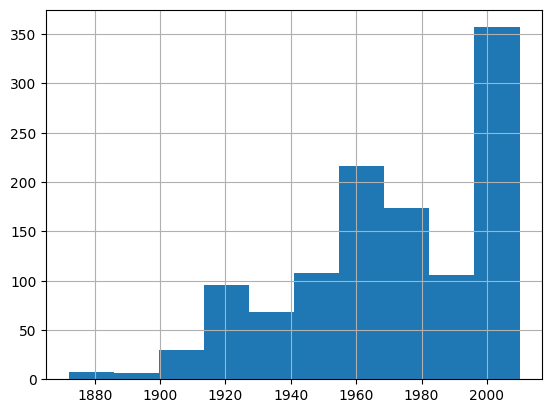

In [115]:
housing['YearBuilt'].hist()


<Axes: >

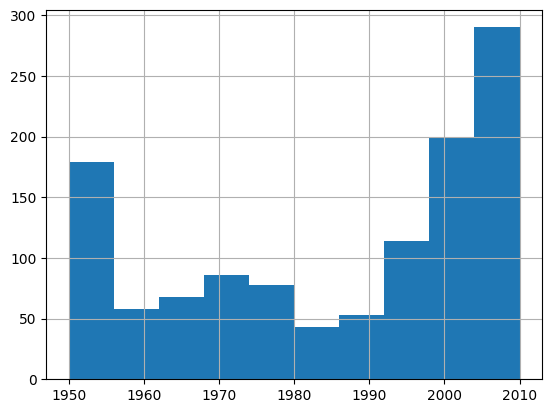

In [116]:
housing['YearRemodAdd'].hist()

In [117]:
default_num_pipeline = make_pipeline(SimpleImputer(strategy='median'),
                                 StandardScaler())
                                 

In [118]:


preprocessing = ColumnTransformer([
    ('totalSF', addition_pipeline(), ['TotalBsmtSF', '1stFlrSF', '2ndFlrSF']),
    ('OverallScore', multiplication_pipeline(), ['OverallQual', 'OverallCond']),
    ('HouseAge', subtraction_pipeline(), ['YrSold', 'YearBuilt']),
    ('YearsSinceRemodel', subtraction_pipeline(), ['YrSold', 'YearRemodAdd']),
    ('GarageScore', multiplication_pipeline(), ['GarageCars', 'GarageArea']),
    ('dist_1960_built', rbf_kernel_pipeline(1960, name='dist_1960_built'), ['YearBuilt']),
    ('dist_2000_built', rbf_kernel_pipeline(2000, name='dist_2000_built'), ['YearBuilt']),
    ('dist_1970_remod', rbf_kernel_pipeline(1970, name='dist_1970_remod'), ['YearRemodAdd']),
    ('dist_2010_remod', rbf_kernel_pipeline(2010, name='dist_2010_remod'), ['YearRemodAdd']),
    ('TotalBath', weighted_bathrooms_pipeline(), ['FullBath', 'HalfBath', 'BsmtFullBath', 'BsmtHalfBath']),
    ('cat', cat_pipeline, make_column_selector(dtype_include=object)),
    ('num', num_pipeline, make_column_selector(dtype_include='number')),
    
    
], remainder=default_num_pipeline)

In [119]:
housing_prepared = preprocessing.fit_transform(housing)
housing_prepared.shape

(1168, 282)

In [120]:
preprocessing.get_feature_names_out()

array(['totalSF__addition', 'OverallScore__multiplication',
       'HouseAge__subtraction', 'YearsSinceRemodel__subtraction',
       'GarageScore__multiplication',
       'dist_1960_built__dist_1960_built_1960',
       'dist_2000_built__dist_2000_built_2000',
       'dist_1970_remod__dist_1970_remod_1970',
       'dist_2010_remod__dist_2010_remod_2010',
       'TotalBath__weighted_bathrooms', 'cat__MSZoning_C (all)',
       'cat__MSZoning_FV', 'cat__MSZoning_RH', 'cat__MSZoning_RL',
       'cat__MSZoning_RM', 'cat__Street_Grvl', 'cat__Street_Pave',
       'cat__LotShape_IR1', 'cat__LotShape_IR2', 'cat__LotShape_IR3',
       'cat__LotShape_Reg', 'cat__LandContour_Bnk',
       'cat__LandContour_HLS', 'cat__LandContour_Low',
       'cat__LandContour_Lvl', 'cat__Utilities_AllPub',
       'cat__Utilities_NoSeWa', 'cat__LotConfig_Corner',
       'cat__LotConfig_CulDSac', 'cat__LotConfig_FR2',
       'cat__LotConfig_FR3', 'cat__LotConfig_Inside',
       'cat__LandSlope_Gtl', 'cat__LandSlope_M

In [121]:
useless_features = [
    'HouseStyle_1.5Unf', 'BsmtCond_None', 'Condition2_Artery', 'Foundation_Stone',
    'GarageQual_Gd', 'SaleCondition_AdjLand', 'HouseStyle_2.5Fin', 'Electrical_Mix',
    'Condition1_RRAe', 'Exterior2nd_AsphShn', 'Exterior2nd_ImStucc', 'SaleType_ConLw',
    'RoofMatl_Membran', 'Exterior2nd_Other', 'GarageCond_Po', 'BsmtCond_Po',
    'Condition2_Feedr', 'Condition1_RRNe', 'Condition1_RRNn', 'Heating_Wall',
    'Condition1_PosA', 'Heating_OthW', 'Exterior1st_AsphShn', 'RoofMatl_Tar&Grv',
    'GarageType_CarPort', 'RoofMatl_WdShngl', 'Foundation_Wood', 'GarageCond_Ex',
    'Condition2_PosA', 'GarageCond_Gd', 'ExterCond_Ex', 'Exterior2nd_CBlock',
    'HeatingQC_Po', 'Neighborhood_Blueste', 'Exterior1st_ImStucc', 'Condition2_RRNn',
    'Electrical_None', 'Utilities_AllPub', 'Heating_Floor', 'Exterior1st_CBlock',
    'Condition2_RRAn', 'Utilities_NoSeWa', 'ExterCond_Po'
]


In [122]:
full_pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('random_forest', RandomForestRegressor(random_state=42)),
])

full_pipeline

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('totalSF',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function addition_name at 0x2876c...
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x28ff85ee0>),
                                                 ('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('logtransformer',
                                                                   LogTransformer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x28fd70740>)])),
                ('random_forest', RandomForestRegressor(random_state=42))])

In [123]:
## this is trying to get the log of the SalePrice label, might be wrong, so come back and delete all the y log

In [124]:
forest_rmse = -cross_val_score(full_pipeline, housing, housing_label, scoring='neg_root_mean_squared_error', cv=10)
forest_rmse

array([22273.73957595, 30574.06221618, 21262.43982662, 27910.03457731,
       25703.332529  , 18807.44995419, 27922.02392983, 21870.45621225,
       42187.70901364, 21523.63152626])

In [125]:
#housing.plot.scatter(x='YearRemodAdd', y='YearBuilt')

In [126]:
param_dist = {'random_forest__max_features': randint(low=2, high=100)}

In [127]:
rnd_search = RandomizedSearchCV(full_pipeline, param_distributions=param_dist, n_iter=10, cv=3, scoring='neg_root_mean_squared_error', random_state=42)

In [128]:
rnd_search.fit(housing, housing_label)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('standardscaler',
                                                                                           StandardScaler())]),
                                                                transformers=[('totalSF',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(feature_names_o...
                                                                                               ('standardscaler',
                                                                                                StandardScaler())]),
                                                                               <sklearn.compose._column_transformer.make_column_selector object at 0x28fd70740>)])),
                                             ('random_forest',
                                              RandomForestRegressor(random_state=42))]),
                   param_distributions={'random_forest__max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x28f7724e0>},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [129]:
final_model = rnd_search.best_estimator_



In [130]:
feature_importance = final_model['random_forest'].feature_importances_
sorted(
    zip(feature_importance, final_model['preprocessing'].get_feature_names_out()),
    reverse=True
)



[(0.2478239542667393, 'totalSF__addition'),
 (0.15691042013380818, 'num__OverallQual'),
 (0.07480870694250238, 'num__GrLivArea'),
 (0.06289236671587105, 'GarageScore__multiplication'),
 (0.04883638811485195, 'num__GarageCars'),
 (0.037798997135718555, 'HouseAge__subtraction'),
 (0.024278765761443055, 'num__YearBuilt'),
 (0.02388542492155106, 'cat__ExterQual_TA'),
 (0.02245149978321965, 'OverallScore__multiplication'),
 (0.021201194300893445, 'num__TotalBsmtSF'),
 (0.02025600276004384, 'TotalBath__weighted_bathrooms'),
 (0.017045657575601017, 'num__GarageArea'),
 (0.0162539746568515, 'cat__BsmtQual_Ex'),
 (0.01596864114950003, 'num__1stFlrSF'),
 (0.013587835918965131, 'dist_2000_built__dist_2000_built_2000'),
 (0.012623376774739872, 'num__LotArea'),
 (0.012088272408926867, 'num__BsmtFinSF1'),
 (0.01006228160543251, 'num__FullBath'),
 (0.008272973098729946, 'YearsSinceRemodel__subtraction'),
 (0.007913224304746329, 'num__2ndFlrSF'),
 (0.007800001655366587, 'num__Fireplaces'),
 (0.0076873

In [131]:
final_model_rmse = -cross_val_score(final_model, housing, housing_label,  scoring='neg_root_mean_squared_error', cv=10)

In [132]:
final_model_rmse

array([22050.2143212 , 28741.70037375, 19084.98876459, 27686.49379756,
       24145.45692553, 17577.98377532, 29696.87293576, 23108.8807138 ,
       40662.46523027, 21650.65476891])

In [133]:
#improvements you can make is add the clustering algoirthm and drop the useless features, but for the sake of time, we will keep moving 

In [134]:
X_test = strat_test_set.drop('SalePrice', axis=1)
y_test = strat_test_set['SalePrice'].copy()

In [135]:
final_prediction = final_model.predict(X_test)
len(final_prediction)

292

In [136]:
final_rmse = root_mean_squared_error(y_test, final_prediction)
final_rmse

36503.503744629284

In [137]:
joblib.dump(final_model, 'my_iowa_housing_model.pkl')

['my_iowa_housing_model.pkl']

In [2]:
def download_kaggle_dataset_test():
    api = KaggleApi()
    api.authenticate()

    dataset = 'house-prices-advanced-regression-techniques'
    file = 'test.csv'
    dataset_path = Path('dataset')
    dataset_path.mkdir(exist_ok=True)
    api.competition_download_file(dataset, file, path=str(dataset_path))
    csv_path = dataset_path / file
    return pd.read_csv(csv_path)
    
    

test = download_kaggle_dataset_test()

len(test)

NameError: name 'KaggleApi' is not defined

In [152]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [140]:
X_test = test.drop(columns=['Id']) 

In [145]:
predictions = final_model.predict(X_test)

len(predictions)

1459

In [148]:
submission = pd.DataFrame({
    'Id': test['Id'],
    'SalePrice': predictions.flatten()
})

In [149]:
submission.to_csv('my_submission.csv', index=False)

In [150]:
!kaggle competitions submit -c house-prices-advanced-regression-techniques -f my_submission.csv -m "My first submission"


100%|██████████████████████████████████████| 20.9k/20.9k [00:00<00:00, 29.9kB/s]
Successfully submitted to House Prices - Advanced Regression Techniques

In [151]:
print(submission.shape)


(1459, 2)


NameError: name 'submission' is not defined